In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 19 11:45:20 2016

@author: johnguttag
"""
import pylab, random
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
class Passenger(object):
    featureNames = ('C1', 'C2', 'C3', 'age', 'male gender')
    def __init__(self, pClass, age, gender, survived, name):
        self.name = name
        self.featureVec = [0, 0, 0, age, gender]
        self.featureVec[pClass - 1] = 1
        self.label = survived
        self.cabinClass = pClass
    def distance(self, other):
        return minkowskiDist(self.featureVec, other.featureVec, 2)
    def getClass(self):
        return self.cabinClass
    def getAge(self):
        return self.featureVec[3]
    def getGender(self):
        return self.featureVec[4]
    def getName(self):
        return self.name
    def getFeatures(self):
        return self.featureVec[:]
    def getLabel(self):
        return self.label

In [3]:
def getTitanicData(fname):
    data = {}
    data['class'], data['survived'], data['age'] = [], [], []
    data['gender'], data['name'] = [], []
    f = open(fname)
    line = f.readline()
    while line != '':
        split = line.split(',')
        data['class'].append(int(split[0]))
        data['age'].append(float(split[1]))
        if split[2] == 'M':
            data['gender'].append(1)
        else:
            data['gender'].append(0)
        if split[3] == '1':
            data['survived'].append('Survived')
        else:
            data['survived'].append('Died')
        data['name'].append(split[4:])
        line = f.readline()
    return data

In [4]:
def buildTitanicExamples(fileName):
    data = getTitanicData(fileName)
    examples = []
    for i in range(len(data['class'])):
        p = Passenger(data['class'][i], data['age'][i],
                      data['gender'][i], data['survived'][i],
                      data['name'][i])
        examples.append(p)
    print('Finishe processing', len(examples), 'passengers\n')    
    return examples
    
examples = buildTitanicExamples('TitanicPassengers.txt')

Finishe processing 1046 passengers



### K-means

In [5]:
def minkowskiDist(v1, v2, p):
    """Assumes v1 and v2 are equal-length arrays of numbers
       Returns Minkowski distance of order p between v1 and v2"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1/p)

In [6]:
def findNearest(name, exampleSet, metric):
    for e in exampleSet:
        if e.getName() == name:
            example = e
            break
    curDist = None
    for e in exampleSet:
        if e.getName() != name:
            if curDist == None or\
               metric(example, e) < curDist:
                nearest = e
                curDist = metric(example, nearest)
    return nearest

In [7]:
def accuracy(truePos, falsePos, trueNeg, falseNeg):
    numerator = truePos + trueNeg
    denominator = truePos + trueNeg + falsePos + falseNeg
    return numerator/denominator

def sensitivity(truePos, falseNeg):
    try:
        return truePos/(truePos + falseNeg)
    except ZeroDivisionError:
        return float('nan')
    
def specificity(trueNeg, falsePos):
    try:
        return trueNeg/(trueNeg + falsePos)
    except ZeroDivisionError:
        return float('nan')
    
def posPredVal(truePos, falsePos):
    try:
        return truePos/(truePos + falsePos)
    except ZeroDivisionError:
        return float('nan')
    
def negPredVal(trueNeg, falseNeg):
    try:
        return trueNeg/(trueNeg + falseNeg)
    except ZeroDivisionError:
        return float('nan')

In [8]:
def getStats(truePos, falsePos, trueNeg, falseNeg, toPrint = True):
    accur = accuracy(truePos, falsePos, trueNeg, falseNeg)
    sens = sensitivity(truePos, falseNeg)
    spec = specificity(trueNeg, falsePos)
    ppv = posPredVal(truePos, falsePos)
    if toPrint:
        print(' Accuracy =', round(accur, 3))
        print(' Sensitivity =', round(sens, 3))
        print(' Specificity =', round(spec, 3))
        print(' Pos. Pred. Val. =', round(ppv, 3))
    return (accur, sens, spec, ppv)

In [9]:
def findKNearest(example, exampleSet, k):
    kNearest, distances = [], []
    #Build lists containing first k examples and their distances
    for i in range(k):
        kNearest.append(exampleSet[i])
        distances.append(example.distance(exampleSet[i]))
    maxDist = max(distances) #Get maximum distance
    #Look at examples not yet considered
    for e in exampleSet[k:]:
        dist = example.distance(e)
        if dist < maxDist:
            #replace farther neighbor by this one
            maxIndex = distances.index(maxDist)
            kNearest[maxIndex] = e
            distances[maxIndex] = dist
            maxDist = max(distances)      
    return kNearest, distances

In [10]:
def KNearestClassify(training, testSet, label, k):
    """Assumes training & testSet lists of examples, k an int
       Predicts whether each example in testSet has label
       Returns number of true positives, false positives,
          true negatives, and false negatives"""
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for testCase in testSet:
        nearest, distances = findKNearest(testCase, training, k)
        #conduct vote
        numMatch = 0
        for i in range(len(nearest)):
            if nearest[i].getLabel() == label:
                numMatch += 1
        if numMatch > k//2: #guess label
            if testCase.getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else: #guess not label
            if testCase.getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

In [11]:
def leaveOneOut(examples, method, toPrint = True):
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(len(examples)):
        testCase = examples[i]
        trainingData = examples[0:i] + examples[i+1:]
        results = method(trainingData, [testCase])
        truePos += results[0]
        falsePos += results[1]
        trueNeg += results[2]
        falseNeg += results[3]
    if toPrint:
        getStats(truePos, falsePos, trueNeg, falseNeg)
    return truePos, falsePos, trueNeg, falseNeg

In [12]:
def split80_20(examples):
    sampleIndices = random.sample(range(len(examples)),
                                  len(examples)//5)
    trainingSet, testSet = [], []
    for i in range(len(examples)):
        if i in sampleIndices:
            testSet.append(examples[i])
        else:
            trainingSet.append(examples[i])
    return trainingSet, testSet

In [13]:
def randomSplits(examples, method, numSplits, toPrint = True):
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    random.seed(0)
    for t in range(numSplits):
        trainingSet, testSet = split80_20(examples)
        results = method(trainingSet, testSet)
        truePos += results[0]
        falsePos += results[1]
        trueNeg += results[2]
        falseNeg += results[3]
    getStats(truePos/numSplits, falsePos/numSplits,
             trueNeg/numSplits, falseNeg/numSplits, toPrint)
    return truePos/numSplits, falsePos/numSplits,\
             trueNeg/numSplits, falseNeg/numSplits

In [14]:
knn = lambda training, testSet:\
             KNearestClassify(training, testSet,
                              'Survived', 3)

In [15]:
numSplits = 10
print('Average of', numSplits,
     '80/20 splits using KNN (k=3)')
truePos, falsePos, trueNeg, falseNeg =\
     randomSplits(examples, knn, numSplits)

print('Average of LOO testing using KNN (k=3)')
truePos, falsePos, trueNeg, falseNeg =\
     leaveOneOut(examples, knn)

Average of 10 80/20 splits using KNN (k=3)
 Accuracy = 0.766
 Sensitivity = 0.67
 Specificity = 0.836
 Pos. Pred. Val. = 0.747
Average of LOO testing using KNN (k=3)
 Accuracy = 0.769
 Sensitivity = 0.663
 Specificity = 0.842
 Pos. Pred. Val. = 0.743


### Logistic Regression

In [16]:
import sklearn.linear_model

def buildModel(examples, toPrint = True):
    featureVecs, labels = [],[]
    for e in examples:
        featureVecs.append(e.getFeatures())
        labels.append(e.getLabel())
    LogisticRegression = sklearn.linear_model.LogisticRegression
    model = LogisticRegression().fit(featureVecs, labels)
    if toPrint:
        print('model.classes_ =', model.classes_)
        for i in range(len(model.coef_)):
            print('For label', model.classes_[1])
            for j in range(len(model.coef_[0])):
                print('   ', Passenger.featureNames[j], '=',
                      model.coef_[0][j])
    return model

In [17]:
def applyModel(model, testSet, label, prob = 0.5):
    testFeatureVecs = [e.getFeatures() for e in testSet]
    probs = model.predict_proba(testFeatureVecs)
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(len(probs)):
        if probs[i][1] > prob:
            if testSet[i].getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else:
            if testSet[i].getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

In [18]:
def lr(trainingData, testData, prob = 0.5):
    model = buildModel(trainingData, False)
    results = applyModel(model, testData, 'Survived', prob)
    return results

### Compare Models

In [19]:
random.seed(0)
numSplits = 10
print('Average of', numSplits, '80/20 splits LR')
truePos, falsePos, trueNeg, falseNeg =\
     randomSplits(examples, lr, numSplits)

Average of 10 80/20 splits LR
 Accuracy = 0.771
 Sensitivity = 0.697
 Specificity = 0.824
 Pos. Pred. Val. = 0.742


In [20]:
print('Average of LOO testing using LR')
truePos, falsePos, trueNeg, falseNeg =\
     leaveOneOut(examples, lr)

Average of LOO testing using LR
 Accuracy = 0.786
 Sensitivity = 0.705
 Specificity = 0.842
 Pos. Pred. Val. = 0.754


In [21]:
#Look at weights
trainingSet, testSet = split80_20(examples)
model = buildModel(trainingSet, True)

model.classes_ = ['Died' 'Survived']
For label Survived
    C1 = 1.6321672452905749
    C2 = 0.45044590123694506
    C3 = -0.5247679152533428
    age = -0.03218073708252884
    male gender = -2.2993057694738526


In [22]:
#Look at changing prob
random.seed(0)
trainingSet, testSet = split80_20(examples)
model = buildModel(trainingSet, False)
print('Try p = 0.1')
truePos, falsePos, trueNeg, falseNeg =\
                  applyModel(model, testSet, 'Survived', 0.1)
getStats(truePos, falsePos, trueNeg, falseNeg)
print('Try p = 0.9')
truePos, falsePos, trueNeg, falseNeg =\
                  applyModel(model, testSet, 'Survived', 0.9)
getStats(truePos, falsePos, trueNeg, falseNeg)

Try p = 0.1
 Accuracy = 0.493
 Sensitivity = 0.976
 Specificity = 0.161
 Pos. Pred. Val. = 0.444
Try p = 0.9
 Accuracy = 0.656
 Sensitivity = 0.176
 Specificity = 0.984
 Pos. Pred. Val. = 0.882


(0.6555023923444976,
 0.17647058823529413,
 0.9838709677419355,
 0.8823529411764706)

In [23]:
def buildROC(trainingSet, testSet, title, plot = True):
    model = buildModel(trainingSet, True)
    xVals, yVals = [], []
    p = 0.0
    while p <= 1.0:
        truePos, falsePos, trueNeg, falseNeg =\
                               applyModel(model, testSet,
                               'Survived', p)
        xVals.append(1.0 - specificity(trueNeg, falsePos))
        yVals.append(sensitivity(truePos, falseNeg))
        p += 0.01
    auroc = sklearn.metrics.auc(xVals, yVals, True)
    if plot:
        pylab.plot(xVals, yVals)
        pylab.plot([0,1], [0,1])
        title = title + '\nAUROC = ' + str(round(auroc,3))
        pylab.title(title)
        pylab.xlabel('1 - specificity')
        pylab.ylabel('Sensitivity')
    return auroc

model.classes_ = ['Died' 'Survived']
For label Survived
    C1 = 1.8185100010800737
    C2 = 0.3663871305443352
    C3 = -0.4817747830201896
    age = -0.036673848200313414
    male gender = -2.2656449739008497


/Users/shawlu/anaconda3/envs/fb/lib/python3.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


0.8611480075901328

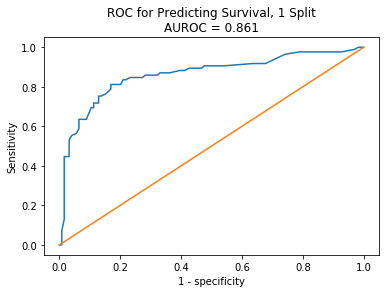

In [24]:
random.seed(0)
trainingSet, testSet = split80_20(examples)
buildROC(trainingSet, testSet, 'ROC for Predicting Survival, 1 Split')